In [1]:
import os
os.environ['XLA_FLAGS']='--xla_gpu_cuda_data_dir=/global/common/software/nersc/cos1.3/cuda/11.3.0'
%pylab inline
import pickle
import numpy as np
import os
import DifferentiableHOS as DHOS
import tensorflow as tf
import cmasher as cmr
from chainconsumer import ChainConsumer

Populating the interactive namespace from numpy and matplotlib


In [2]:
field_size=5.
field_npix=1024
pix_scale = 5/1024*60# arcmin


In [3]:
# Load maps 
kmaps = []
for filename in os.listdir("/pscratch/sd/d/dlan/result_paper_IA_0/maps/"):
        res =pickle.load(open(os.path.join('/pscratch/sd/d/dlan/result_paper_IA_0/maps/', filename), 'rb'))
        kmaps.append(res['kmap'])

2022-09-16 07:19:04.968162: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-16 07:19:05.983828: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38280 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:c3:00.0, compute capability: 8.0


In [4]:
def rebin(a, shape):
    sh = shape, a.shape[0] // shape
    return tf.math.reduce_mean(tf.reshape(a, sh), axis=-1)

In [5]:
from flowpm.fourier_smoothing import fourier_smoothing
def desc_y1_analysis(kmap):
    """
  Adds noise and apply smoothing we might expect in DESC Y1 SRD setting
  """
    ngal = 10
    pix_scale = field_size / field_npix * 60
    ngal_per_pix = ngal * pix_scale**2
    sigma_e = 0.26 / np.sqrt(2 * ngal_per_pix)
    kmap = kmap + sigma_e * tf.random.normal(kmap.shape)
    return kmap

In [6]:
psms=[]
for i in range(len(kmaps)):
    kmap =desc_y1_analysis(kmaps[i])
    ell, power_spectrum = DHOS.statistics.power_spectrum_mulscale(
    kmap, field_size, field_npix)
    ell = ell[2:46]
    power_spectrum = power_spectrum[2:46]
    ell = rebin(ell, 11)
    ps = rebin(power_spectrum, 11)
    psms.append(ps)

2022-09-16 07:19:23.510225: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-09-16 07:19:23.630030: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8302


In [7]:
mupsms = stack(psms, axis=0).mean(axis=0)

In [8]:
ps_jac= []
for filename in os.listdir("/pscratch/sd/d/dlan/result_paper_IA_0/jac_ps_multiscale"):
        res =pickle.load(open(os.path.join('/pscratch/sd/d/dlan/result_paper_IA_0/jac_ps_multiscale', filename), 'rb'))
        ps_jac.append(res['jac'])
ps_jac = stack(ps_jac, axis=0)

In [9]:
# Computing covariance matrix
f_sky=25/150000
cov_ps=np.cov(psms, rowvar=False)*f_sky
fac_ps=np.sqrt(np.diag(cov_ps))


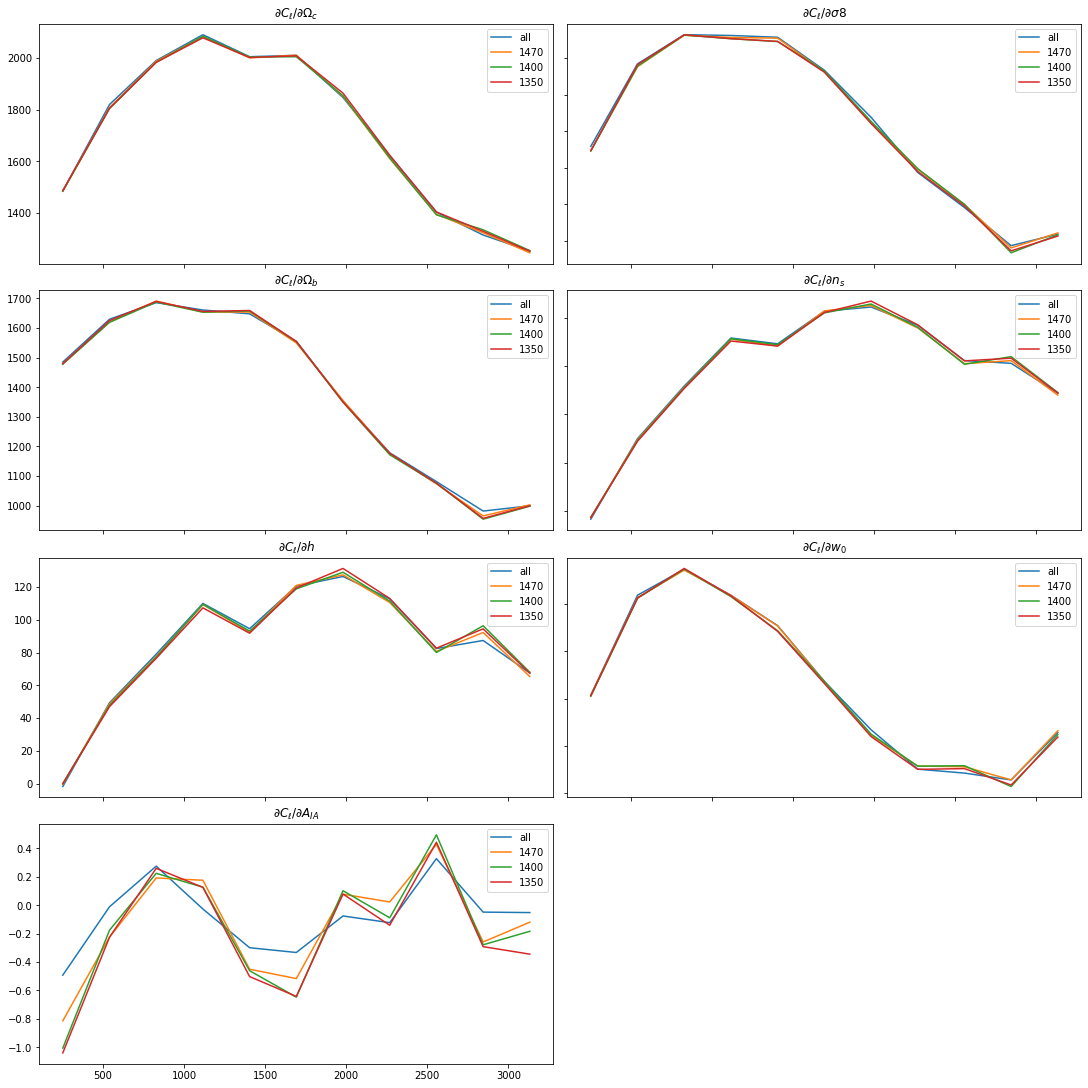

In [10]:
labels=["$\Omega_c$","$\sigma8$","$\Omega_b$","$n_s$","$h$","$w_0$","$A_{IA}$"]
figsize = (15, 15)
fig =plt.figure(figsize=figsize, constrained_layout=True)
cols = 2
rows =4
ax = fig.subplots(rows, cols)
for j in range(7):
    ax.flatten()[j].plot(ell,ps_jac[:,:,:].mean(axis=0)[...,j]/fac_ps,label='all')
    ax.flatten()[j].plot(ell,ps_jac[:1470,:,:].mean(axis=0)[...,j]/fac_ps,label='1470')
    ax.flatten()[j].plot(ell,ps_jac[:1400,:,:].mean(axis=0)[...,j]/fac_ps,label='1400')
    ax.flatten()[j].plot(ell,ps_jac[:1350,:,:].mean(axis=0)[...,j]/fac_ps,label='1350')
    ax.flatten()[j].set_title('$\partial C_\ell/\partial$' +str(labels[j]))
    ax.flatten()[j].legend()
    # Hide x labels and tick labels for top plots and y ticks for right plots.
    ax.flatten()[j].label_outer()
for i in range(7,8):
    ax.flatten()[i].remove()

# Validate the stability of the fisher contours

In [11]:


cov=np.cov(tf.reshape(psms,[len(psms),11]), rowvar=False)*f_sky


#1500
dmu = ps_jac[:1500,:,:].mean(axis=0)
Fp = dmu.T @ (np.linalg.inv(cov)) @ dmu

#1400
dmu_4 = ps_jac[:1400,:,:].mean(axis=0)
Fp_4 = dmu_4.T @ (np.linalg.inv(cov)) @ dmu_4

#1300
dmu_3 =ps_jac[:1300,:,:].mean(axis=0)
Fp_3 = dmu_3.T @ (np.linalg.inv(cov)) @ dmu_3


#1200
dmu_2 = ps_jac[:1200,:,:].mean(axis=0)
Fp_2 = dmu_2.T @ (np.linalg.inv(cov)) @ dmu_2


#1100
dmu_1 = ps_jac[:1100,:,:].mean(axis=0)
Fp_1 = dmu_1.T @ (np.linalg.inv(cov)) @ dmu_1

#1000
dmu_0 = ps_jac[:1000,:,:].mean(axis=0)
Fp_0 = dmu_0.T @ (np.linalg.inv(cov)) @ dmu_0

#900
dmu_9 = ps_jac[:900,:,:].mean(axis=0)
Fp_9 = dmu_9.T @ (np.linalg.inv(cov)) @ dmu_9

In [12]:
fid_params=np.array([0.2589, 0.8159, 0.04860, 0.9667, 0.6774, -1.0, 0. ])

In [13]:
col = cmr.tropical

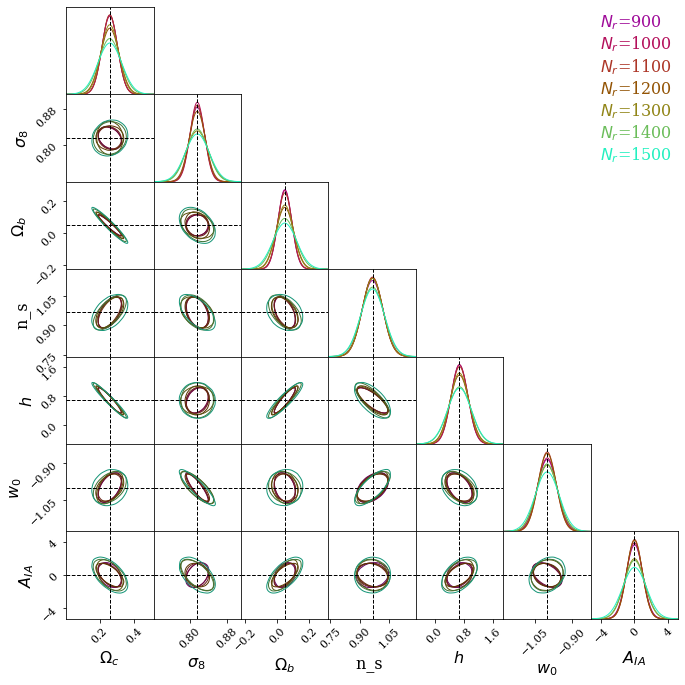

In [14]:
c = ChainConsumer()
##########
c.add_covariance(fid_params , np.linalg.inv(Fp_9), 
                 parameters=["$\Omega_c$", "$\sigma_8$","$\Omega_b$","n_s","$h$","$w_0$", "$A_{IA}$"], name="$N_r$=900")
###########
c.add_covariance(fid_params , np.linalg.inv(Fp_0), 
                 parameters=["$\Omega_c$", "$\sigma_8$","$\Omega_b$","n_s","$h$","$w_0$", "$A_{IA}$"], name="$N_r$=1000")
##########
c.add_covariance(fid_params , np.linalg.inv(Fp_1), 
                 parameters=["$\Omega_c$", "$\sigma_8$","$\Omega_b$","n_s","$h$","$w_0$", "$A_{IA}$"], name="$N_r$=1100")
###########
c.add_covariance(fid_params , np.linalg.inv(Fp_2), 
                 parameters=["$\Omega_c$", "$\sigma_8$","$\Omega_b$","n_s","$h$","$w_0$", "$A_{IA}$"], name="$N_r$=1200")
###########
c.add_covariance(fid_params , np.linalg.inv(Fp_3), 
                 parameters=["$\Omega_c$", "$\sigma_8$","$\Omega_b$","n_s","$h$","$w_0$", "$A_{IA}$"], name="$N_r$=1300")
###########
c.add_covariance(fid_params , np.linalg.inv(Fp_4), 
                 parameters=["$\Omega_c$", "$\sigma_8$","$\Omega_b$","n_s","$h$","$w_0$", "$A_{IA}$"], name="$N_r$=1400")
###########
c.add_covariance(fid_params , np.linalg.inv(Fp), 
                 parameters=["$\Omega_c$", "$\sigma_8$","$\Omega_b$","n_s","$h$","$w_0$", "$A_{IA}$"], name="$N_r$=1500")

c.configure(usetex=False, max_ticks=3,tick_font_size=11, label_font_size=16,sigmas=[0,1],spacing=0.0,cmap=col)
fig = c.plotter.plot(figsize="column", truth=fid_params)
fig.set_size_inches(5 + fig.get_size_inches())
#plt.savefig('../../figures/Fisher_stability_ps.pdf')
